# DiploDatos 2019 - Población Penitenciaria en Argentina




> http://diplodatos.famaf.unc.edu.ar/poblacion-penitenciaria-en-argentina-2002-a-2017/




## Práctico Introducción al Aprendizaje Automático

En este práctico utilizaremos algunos algoritmos básicos de aprendizaje automático para intentar encontrar patrones en los datos, y evaluaremos los resultados usando métricas estándares para cada tipo de problema. 

El objetivo del práctico es que pensemos en las distintas formas que puede tomar el modelado de un problema con datos, y en el trabajo de selección de features que debe realizarse para poder abordarlo.

Para ello intentaremos responder la siguiente pregunta:

¿Es posible predecir la duración de la condena que recibirá una persona en base a datos como los que se encuentran presentes en este dataset?

Tener en cuenta los siguientes lineamientos:  

- Utilicen los registros del año 2017. 
- Deben decidir a partir de qué valor de una métrica determinada consideran aceptable el resultado. Esto lo tienen que hacer antes de empezar a entrenar un modelo.
- Sólo pueden utilizar las variables que corresponden a información generada antes que la persona ingrese a la institución penal.
- Deberán trabajar con el problema de dos maneras diferentes: como un problema de regresión, y como un problema de clasificación.
- A la hora de hacer selección de variables, tengan en cuenta que los modelos de Machine Learning solo reciben inputs numéricos.
- Es importante que almacenen los resultados de alguna manera para poder comparar los distintos modelos. Recomendación: crear una función para almacenar resultados en un dataframe de pandas e imprimirlos en pantalla. 

#### Inicialización y carga de datos

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error, explained_variance_score, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

import graphviz
import pprint

np.random.seed(0)

pd.set_option('display.max_columns', 60)

In [2]:
# Ejemplo, modificar acorde a la ubicación donde tengan su set de datos
data_raw = pd.read_csv('../datasets/sneep_2017_diplodatos.csv', index_col=0)

/home/lucia/.anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data_raw.sample(5)

,anio_censo,provincia_descripcion,establecimiento_descripcion,edad,genero_descripcion,nacionalidad_descripcion,estado_civil_descripcion,nivel_instruccion_descripcion,ultima_situacion_laboral_descripcion,capacitacion_laboral_al_ingresar_descripcion,ultimo_lugar_residencia_descripcion,ultima_provincia_residencia_descripcion,jurisdiccion_descripcion,situacion_legal_descripcion,fecha_detencion,fecha_condenado,establecimiento_procedencia_descripcion,delito1_descripcion,delito2_descripcion,delito3_descripcion,delito4_descripcion,delito5_descripcion,horas_trabajo_remunerado_descripcion,participacion_programa_laboral,participacion_programa_educativo_descripcion,participacion_actividades_deportivas,recibio_atencion_medica_ult_anio_descripcion,recibio_visitas_ultimo_anio,participo_alteracion_orden_ult_anio_descripcion,tipo_infraccion_disciplinaria_descripcion,sancion_aplicada_descripcion,calificacion_conducta_descripcion,tentativa_fugas_evasiones_descripcion,tentativa_suicidio,fue_lesionado_descripcion,duracion_condena_anios,duracion_condena_meses,duracion_condena_rango,tipo_condena,tiene_medidas_seguridad,es_reincidente_descripcion,tiene_periodo_progresividad_descripcion,reparticion_descripcion,tuvo_salidas_transitorias_descripcion,incorporado_reg_semi_libertad_descripcion,participa_programa_pre_libertad,participa_programa_prision_discontinua_descripcion,participa_programa_semi_detencion_descripcion,tuvo_reduccion_pena_descripcion,mujer_tiene_hijos_intramuro
53495,2017,Chaco,SPF - U. 7 PRISION REGIONAL DEL NORTE,45.0,Masculino,Argentina,Soltero,Primario completo,Desocupado,No tiene ni oficio ni profesión,Urbano,Ciudad de Buenos Aires,FEDERAL,Condenado,1994-07-15,2012-04-12,Deriv. de otro establecimiento,Homicidios dolosos,NaN,NaN,NaN,NaN,Hasta 40 hs. Semanales,1.0,Si - educación formal - SECUNDARIA (Polimodal),1.0,SI - HIPERTENSIÓN,1.0,No participó de ninguna alteración,No cometió Infracción disciplinaria,NaN,Ejemplar,No,0.0,No fue lesionado,30.0,6.0,7,0.0,3.0,Reincidente,Período de tratamiento,Federal,No le fueron otorgadas,No está incorporado al régimen de semilibertad,1.0,No está incorporado,No tiene semidetención,No tuvo reducción de pena,NaN
75586,2017,San Luis,COMPLEJO PENITENCIARIO PROVINCIAL - UNIDAD 2 ...,25.0,Masculino,Argentina,Soltero,Secundario incompleto,Trabajador de tiempo parcial,Tiene algún oficio,Urbano,Mendoza,FEDERAL,Procesado,2017-04-19,NaN,Deriv. de una instit. Policial,Infracción ley n° 23.737 (estupefacientes),NaN,NaN,NaN,NaN,No tiene trabajo remunerado,0.0,No participa de ningún programa educativo,1.0,Si - Recibió Asistencia Médica,1.0,"SI - Alteración del orden SIN heridos, ni rehenes",Faltas graves,Otra Sanción,Sin calificación,No,0.0,No fue lesionado,0.0,0.0,0,NaN,0.0,NaN,NaN,Provincial,NaN,NaN,0.0,NaN,NaN,NaN,NaN
181,2017,Buenos Aires,UNIDAD 13 - JUNIN,42.0,Masculino,Argentina,Soltero,Secundario completo,Trabajador de tiempo parcial,Tiene alguna profesión,Urbano,Buenos Aires,PROVINCIAL - Buenos Aires,Procesado,2016-04-26,NaN,Deriv. de otro establecimiento,Violaciones,NaN,NaN,NaN,NaN,No tiene trabajo remunerado,0.0,No participa de ningún programa educativo,1.0,SI - ASMA O EPOC,1.0,No participó de ninguna alteración,No cometió Infracción disciplinaria,NaN,NaN,No,0.0,No fue lesionado,0.0,0.0,0,NaN,0.0,NaN,NaN,Provincial,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3530,2017,Buenos Aires,UNIDAD 33 - LOS HORNOS (MUJERES),42.0,Femenino,Argentina,Soltero,Primario completo,Desocupado,No tiene ni oficio ni profesión,Urbano,Buenos Aires,PROVINCIAL - Buenos Aires,Condenado,2015-08-01,2013-02-27,Ingreso directo,Otros delitos contra la propiedad,NaN,NaN,NaN,NaN,No tiene trabajo remunerado,0.0,Si - educación formal - SECUNDARIA (Polimodal),0.0,SI - HIV,1.0,No participó de ninguna alteración,Faltas media,Exclus. de activ. recreat/dep. hasta 10 días,Ejemplar,No,0.0,No fue lesionado,5.0,0.0,2,0.0,1.0,Primario,No se aplica ninguna,Provincial,No le fueron otorgadas,No está incorporado al régimen de semilibertad,1.0,No está incorporado,No tie

### Regresión

1- Filtrar los registros, conservar sólo aquellos que tengan condena

In [4]:
## Campos que estan relacionados con la condena
for col in data_raw.columns:
    if 'condena' in col:
        print(col)

fecha_condenado
duracion_condena_anios
duracion_condena_meses
duracion_condena_rango
tipo_condena


In [5]:
data_raw.columns

Index(['anio_censo', 'provincia_descripcion', 'establecimiento_descripcion',
       'edad', 'genero_descripcion', 'nacionalidad_descripcion',
       'estado_civil_descripcion', 'nivel_instruccion_descripcion',
       'ultima_situacion_laboral_descripcion',
       'capacitacion_laboral_al_ingresar_descripcion',
       'ultimo_lugar_residencia_descripcion',
       'ultima_provincia_residencia_descripcion', 'jurisdiccion_descripcion',
       'situacion_legal_descripcion', 'fecha_detencion', 'fecha_condenado',
       'establecimiento_procedencia_descripcion', 'delito1_descripcion',
       'delito2_descripcion', 'delito3_descripcion', 'delito4_descripcion',
       'delito5_descripcion', 'horas_trabajo_remunerado_descripcion',
       'participacion_programa_laboral',
       'participacion_programa_educativo_descripcion',
       'participacion_actividades_deportivas',
       'recibio_atencion_medica_ult_anio_descripcion',
       'recibio_visitas_ultimo_anio',
       'participo_alteracion_orde

In [6]:
def remove_descripcion(data):
    """
    Eimina las columnas con descripciones
    """
    rename_dict = {}
    for col in data.columns:
        if 'descripcion' in col:
            rename_dict[col] = '_'.join(col.split('_')[:-1])
    data = data.rename(columns=rename_dict, inplace=False)
    return data

def filtrar_condena(data):
    """
    Elimina los registros que no tienen condena
    """
    mask = data.tipo_condena.notnull()
    #print(mask)
    filtered_data = data[mask]
    filtered_data.tipo_condena.astype('int')
    return filtered_data

def eliminar_columnas(data):
    """
    Elimina columnas que no son de interés
    """
    drop_cols = [
        'tuvo_reduccion_pena',
        'participa_programa_semi_detencion',
        'participa_programa_prision_discontinua',
        'tiene_periodo_progresividad',
        'tuvo_salidas_transitorias',
        'incorporado_reg_semi_libertad',
        'participa_programa_pre_libertad',
        'situacion_legal',
        'participacion_programa_laboral',
        'participacion_programa_educativo',
        'participacion_actividades_deportivas',
        'recibio_atencion_medica_ult_anio',
        'recibio_visitas_ultimo_anio',
        'participo_alteracion_orden_ult_anio',
        'tipo_infraccion_disciplinaria',
        'sancion_aplicada',
        'calificacion_conducta',
        'tentativa_fugas_evasiones',
        'tentativa_suicidio',
        'horas_trabajo_remunerado',
        'fue_lesionado',
        'anio_censo'
    ]
    data = data.drop(drop_cols, axis=1)
    return data

def encode_data(data):
    """
    Crea variables dummies que indican la provincia
    """
    dummy_cols = [
        'provincia'
    ]
    data = pd.get_dummies(data, columns=dummy_cols)
    return data

filtered_data = remove_descripcion(data_raw)
filtered_data = filtrar_condena(filtered_data)
filtered_data = eliminar_columnas(filtered_data)
filtered_data = encode_data(filtered_data)

print(filtered_data.shape)
filtered_data.head()

(43457, 51)


,establecimiento,edad,genero,nacionalidad,estado_civil,nivel_instruccion,ultima_situacion_laboral,capacitacion_laboral_al_ingresar,ultimo_lugar_residencia,ultima_provincia_residencia,jurisdiccion,fecha_detencion,fecha_condenado,establecimiento_procedencia,delito1,delito2,delito3,delito4,delito5,duracion_condena_anios,duracion_condena_meses,duracion_condena_rango,tipo_condena,tiene_medidas_seguridad,es_reincidente,reparticion,mujer_tiene_hijos_intramuro,provincia_Buenos Aires,provincia_Catamarca,provincia_Chaco,provincia_Chubut,provincia_Ciudad de Buenos Aires,provincia_Corrientes,provincia_Córdoba,provincia_Entre Rios,provincia_Formosa,provincia_Jujuy,provincia_La Pampa,provincia_La Rioja,provincia_Mendoza,provincia_Misiones,provincia_Neuquén,provincia_Río Negro,provincia_Salta,provincia_San Juan,provincia_San Luis,provincia_Santa Cruz,provincia_Santa Fe,provincia_Santiago del Estero,provincia_Tierra del Fuego,provincia_Tucumán
0,UNIDAD 13 - JUNIN,28.0,Masculino,Argentina,Soltero,Primario incompleto,Desocupado,No tiene ni oficio ni profesión,Urbano,Buenos Aires,PROVINCIAL - Buenos Aires,2017-02-23,2017-08-11,Deriv. de una instit. Policial,Otros delitos contra las personas,Amenazas,NaN,NaN,NaN,2.0,2.0,1,0.0,1.0,Primario,Provincial,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
282,UNIDAD 13 - JUNIN,37.0,Masculino,Argentina,Casado,Ninguno,Desocupado,No tiene ni oficio ni profesión,Urbano,Buenos Aires,PROVINCIAL - Buenos Aires,2017-02-03,2017-12-03,Deriv. de otro establecimiento,Delitos contra la seguridad pública,NaN,NaN,NaN,NaN,3.0,10.0,2,0.0,1.0,Primario,Provincial,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
283,UNIDAD 13 - JUNIN,22.0,Masculino,Argentina,Casado,Primario completo,Trabajador de tiempo parcial,Tiene alguna profesión,Urbano,Buenos Aires,PROVINCIAL - Buenos Aires,2013-03-31,2013-05-14,Deriv. de otro establecimiento,Robo y/o tentativa de robo,NaN,NaN,NaN,NaN,5.0,0.0,2,0.0,1.0,Primario,Provincial,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
284,UNIDAD 13 - JUNIN,23.0,Masculino,Argentina,Viudo,Primario incompleto,Desocupado,Tiene alguna profesión,Urbano,Buenos Aires,PROVINCIAL - Buenos Aires,2015-02-02,2016-10-11,Deriv. de otro establecimiento,Homicidios dolosos (tent.),NaN,NaN,NaN,NaN,8.0,7.0,3,0.0,1.0,Primario,Provincial,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
285,UNIDAD 13 - JUNIN,23.0,Masculino,Paraguaya,Casado,Primario completo,Desocupado,Tiene alguna profesión,Urbano,Buenos Aires,PROVINCIAL - Buenos Aires,2016-02-24,2017-05-14,Deriv. de otro establecimiento,Infracción ley n° 23.737 (estupefacientes),NaN,NaN,NaN,NaN,4.0,3.0,2,0.0,1.0,Primario,Provincial,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
filtered_data.columns

Index(['establecimiento', 'edad', 'genero', 'nacionalidad', 'estado_civil',
       'nivel_instruccion', 'ultima_situacion_laboral',
       'capacitacion_laboral_al_ingresar', 'ultimo_lugar_residencia',
       'ultima_provincia_residencia', 'jurisdiccion', 'fecha_detencion',
       'fecha_condenado', 'establecimiento_procedencia', 'delito1', 'delito2',
       'delito3', 'delito4', 'delito5', 'duracion_condena_anios',
       'duracion_condena_meses', 'duracion_condena_rango', 'tipo_condena',
       'tiene_medidas_seguridad', 'es_reincidente', 'reparticion',
       'mujer_tiene_hijos_intramuro', 'provincia_Buenos Aires',
       'provincia_Catamarca', 'provincia_Chaco', 'provincia_Chubut',
       'provincia_Ciudad de Buenos Aires', 'provincia_Corrientes',
       'provincia_Córdoba', 'provincia_Entre Rios', 'provincia_Formosa',
       'provincia_Jujuy', 'provincia_La Pampa', 'provincia_La Rioja',
       'provincia_Mendoza', 'provincia_Misiones', 'provincia_Neuquén',
       'provincia_Río Ne

2- La variable a predecir que utilizaremos será la condena en meses, generar la feature correspondiente, anexarla al dataset

In [8]:
filtered_data.dropna(subset=['duracion_condena_anios', 'duracion_condena_meses'],inplace=True)
filtered_data['duracion_condena'] = 12*filtered_data['duracion_condena_anios'] + \
                                       filtered_data['duracion_condena_meses']

3- Generar dataframe con las variables de tipo "delito_xx" y la feature generada en el paso anterior. Dividir los datos en conjunto de training y test.

In [9]:
delito_columns = ['delito{:d}'.format(i) for i in range(1, 6)]
columns = delito_columns + ['duracion_condena']
data = filtered_data[columns]
df1 = pd.DataFrame(data, columns=columns)
df1.head()

,delito1,delito2,delito3,delito4,delito5,duracion_condena
0,Otros delitos contra las personas,Amenazas,NaN,NaN,NaN,26.0
282,Delitos contra la seguridad pública,NaN,NaN,NaN,NaN,46.0
283,Robo y/o tentativa de robo,NaN,NaN,NaN,NaN,60.0
284,Homicidios dolosos (tent.),NaN,NaN,NaN,NaN,103.0
285,Infracción ley n° 23.737 (estupefacientes),NaN,NaN,NaN,NaN,51.0


In [10]:
# Le asignamos un número del 0 al 27 a cada tipo de delito y -1 a los NaN
df_delitos = df1.copy()
df_delitos[delito_columns] = df_delitos[delito_columns].astype('category')

d = dict(enumerate(df_delitos['delito1'].cat.categories))
pprint.pprint(d)

{0: 'Amenazas',
 1: 'Contravenciones',
 2: 'Del. contra la lib. comet. por func. público',
 3: 'Delitos c/ el estado civil',
 4: 'Delitos c/ la administracion pública',
 5: 'Delitos c/ la fe pública',
 6: 'Delitos c/el orden público',
 7: 'Delitos contra el honor',
 8: 'Delitos contra la seguridad de la nación',
 9: 'Delitos contra la seguridad pública',
 10: 'Delitos contra los poderes publicos',
 11: 'Delitos previstos en leyes especiales',
 12: 'Homicidios Culposos',
 13: 'Homicidios dolosos',
 14: 'Homicidios dolosos (tent.)',
 15: 'Hurto y/o tentativa de hurto',
 16: 'Infraccion ley n° 13.944 incumplimiento de deberes',
 17: 'Infraccion ley n° 24.769 penal tributaria',
 18: 'Infracción ley n° 23.737 (estupefacientes)',
 19: 'Lesiones Culposas',
 20: 'Lesiones Dolosas',
 21: 'Otros delitos contra la integridad sexual',
 22: 'Otros delitos contra la libertad',
 23: 'Otros delitos contra la propiedad',
 24: 'Otros delitos contra las personas',
 25: 'Privación ilegítima de la libertad

In [11]:
cat_columns = df_delitos.select_dtypes(['category']).columns
df_delitos[cat_columns] = df_delitos[cat_columns].apply(lambda x: x.cat.codes)
df_delitos.head()

,delito1,delito2,delito3,delito4,delito5,duracion_condena
0,24,0,-1,-1,-1,26.0
282,9,-1,-1,-1,-1,46.0
283,26,-1,-1,-1,-1,60.0
284,14,-1,-1,-1,-1,103.0
285,18,-1,-1,-1,-1,51.0


In [12]:
X = df_delitos[delito_columns]
y = df_delitos['duracion_condena']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

4- Generar un modelo baseline, esto es, un modelo "tonto" que devuelva siempre el promedio de las condenas para el crimen cometido (usaremos solo delito1_id). Calcular 3 métricas de evaluación de regresiones para este modelo. 

In [13]:
def predict_condena_naive(X_train, X_test, y_train):
    """
    Predice la condena utilizando el promedio para ese delito
    """
    y_pred = np.zeros(X_test.shape[0])
    for i, x in enumerate(X_test):
        mask = X_train == x
        y_pred[i] = y_train[mask].mean()       
    return y_pred

def regression_results(y_true, y_pred):
    """
    Computa métricas de evaluación del modelo
    """
    explained_variance = explained_variance_score(y_true, y_pred)
    mean_abs_er = mean_absolute_error(y_true, y_pred) 
    mse = mean_squared_error(y_true, y_pred) 
    mean_sq_log_er = mean_squared_log_error(y_true, y_pred)
    median_abs_er = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print('--------------------------------------------------------------------------------------------')
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_sq_log_er,4))
    print('r2: ', round(r2,4))
    print('mean_abs_error: ', round(mean_abs_er,4))
    print('median_abs_error: ', round(median_abs_er,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('--------------------------------------------------------------------------------------------')

In [14]:
X1_train, X1_test = X_train['delito1'], X_test['delito1']

y_pred = predict_condena_naive(X1_train, X1_test, y_train)
regression_results(y_test, y_pred)

--------------------------------------------------------------------------------------------
explained_variance:  0.1362
mean_squared_log_error:  1.7526
r2:  0.1361
mean_abs_error:  42.4614
median_abs_error:  27.4457
MSE:  3617.5579
RMSE:  60.1461
--------------------------------------------------------------------------------------------


Las métricas indican que la predicción no es buena. De todas formas imprimimos la tabla con los resultados para visualizarlos.

In [15]:
def reg_table(X_test, y_test, y_pred):
    """
    Imprime una tabla con las predicciones del modelo, los resultados reales
    y la distancia entre estos dos valores
    """
    if type(X_test) is not pd.DataFrame:
        XX = X_test.to_frame().reset_index() #lo convierto en un dataframe
    else:
        XX = X_test.reset_index()
 
    yy = y_test.to_frame().reset_index()
    yy = yy.drop(['index'], axis=1)

    yyy = pd.DataFrame([y_pred]).T
    yyy.columns = ['condena_predicha']

    table = pd.concat([XX, yy, yyy], axis=1)    
    table['error'] = abs(table['duracion_condena'] - table['condena_predicha'])
    return table

# Resultados del modelo
naive_table = reg_table(X1_test, y_test, y_pred)
naive_table.head()

,index,delito1,duracion_condena,condena_predicha,error
0,31471,27,104.0,123.253873,19.253873
1,16032,26,144.0,75.445658,68.554342
2,57392,26,44.0,75.445658,31.445658
3,73349,18,54.0,59.745680,5.745680
4,6810,26,4.0,75.445658,71.445658


5- Entrenar una regresión lineal y un árbol de decisión usando solo las variables de tipo "delito_xx". Evaluar métricas para el conjunto de training y para test.

In [16]:
## Linear regressor
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)
regression_results(y_test, y_pred_lin_reg)

## Tree regressor
tree_reg = DecisionTreeRegressor().fit(X_train, y_train)
y_pred_tree_reg = tree_reg.predict(X_test)
regression_results(y_test, y_pred_tree_reg)

--------------------------------------------------------------------------------------------
explained_variance:  0.0077
mean_squared_log_error:  1.7963
r2:  0.0077
mean_abs_error:  48.8336
median_abs_error:  38.8244
MSE:  4155.6329
RMSE:  64.4642
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
explained_variance:  0.1006
mean_squared_log_error:  1.8006
r2:  0.1006
mean_abs_error:  42.5014
median_abs_error:  28.0182
MSE:  3766.6029
RMSE:  61.3727
--------------------------------------------------------------------------------------------


Las métricas indican que el árbol de decisión predice mejor que el regresor lineal. Aún así, ambas predicciones son bastante malas. De todas formas vamos a visualizarlas.

In [17]:
# Resultados regresión lineal
lin_reg_table = reg_table(X_test, y_test, y_pred_lin_reg)
lin_reg_table.head()

,index,delito1,delito2,delito3,delito4,delito5,duracion_condena,condena_predicha,error
0,31471,27,-1,-1,-1,-1,104.0,86.129574,17.870426
1,16032,26,-1,-1,-1,-1,144.0,86.206780,57.793220
2,57392,26,23,-1,-1,-1,44.0,96.665362,52.665362
3,73349,18,-1,-1,-1,-1,54.0,86.824424,32.824424
4,6810,26,-1,-1,-1,-1,4.0,86.206780,82.206780


In [18]:
# Resultados árbol de desición
tree_reg_table = reg_table(X_test, y_test, y_pred_tree_reg)
tree_reg_table.head()

,index,delito1,delito2,delito3,delito4,delito5,duracion_condena,condena_predicha,error
0,31471,27,-1,-1,-1,-1,104.0,120.747375,16.747375
1,16032,26,-1,-1,-1,-1,144.0,72.064682,71.935318
2,57392,26,23,-1,-1,-1,44.0,62.832258,18.832258
3,73349,18,-1,-1,-1,-1,54.0,59.631623,5.631623
4,6810,26,-1,-1,-1,-1,4.0,72.064682,68.064682


In [19]:
# Gráfico del árbol
dot_data = tree.export_graphviz(tree_reg, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("arbol1") 
#graph

'arbol1.pdf'

6- Seleccionar 3 variables adicionales para entrenar los modelos. Generar nuevamente conjuntos de training y test. Entrenar y evaluar los modelos de regresión lineal y árbol de decisión.

In [20]:
variables  = ['genero', 'nivel_instruccion', 'ultima_situacion_laboral']
feature_columns = variables + delito_columns
columns = feature_columns + ['duracion_condena']
data = filtered_data[columns]
df2 = pd.DataFrame(data, columns=columns)
df2

df_delitos2 = df2.copy()
df_delitos2[feature_columns] = df_delitos2[feature_columns].astype('category')
cat_columns = df_delitos2.select_dtypes(['category']).columns
df_delitos2[cat_columns] = df_delitos2[cat_columns].apply(lambda x: x.cat.codes)

X = df_delitos2[feature_columns]
y = df_delitos2['duracion_condena']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

print('######################################################################################')
print('########################## LINEAR REGRESSION #########################################')
print('######################################################################################')
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)
regression_results(y_test, y_pred_lin_reg)

print('######################################################################################')
print('############################ DESICION TREE ###########################################')
print('######################################################################################')
tree_reg = DecisionTreeRegressor().fit(X_train, y_train)
y_pred_tree_reg = tree_reg.predict(X_test)
regression_results(y_test, y_pred_tree_reg)

######################################################################################
########################## LINEAR REGRESSION #########################################
######################################################################################
--------------------------------------------------------------------------------------------
explained_variance:  0.0048
mean_squared_log_error:  1.7536
r2:  0.0048
mean_abs_error:  48.5038
median_abs_error:  39.3207
MSE:  4146.4491
RMSE:  64.3929
--------------------------------------------------------------------------------------------
######################################################################################
############################ DESICION TREE ###########################################
######################################################################################
--------------------------------------------------------------------------------------------
explained_variance:  0.0563
mean_squared_log

Según las métricas, estos modelos son muy malos. Probamos eligiendo otras variables y no mejora.

In [22]:
# Resultados regresión lineal
lin_reg_table = reg_table(X_test, y_test, y_pred_lin_reg)
lin_reg_table.head()

,index,genero,nivel_instruccion,ultima_situacion_laboral,delito1,delito2,delito3,delito4,delito5,duracion_condena,condena_predicha,error
0,53872,1,2,0,26,-1,-1,-1,-1,42.0,84.979482,42.979482
1,43480,1,1,2,21,-1,-1,-1,-1,252.0,87.947770,164.052230
2,52104,1,1,2,26,-1,-1,-1,-1,42.0,87.434047,45.434047
3,2968,1,1,2,4,20,-1,-1,-1,44.0,100.333542,56.333542
4,29639,1,3,2,26,-1,-1,-1,-1,24.0,87.409572,63.409572


In [23]:
# Resultados árbol de desición
tree_reg_table = reg_table(X_test, y_test, y_pred_tree_reg)
tree_reg_table.head()

,index,genero,nivel_instruccion,ultima_situacion_laboral,delito1,delito2,delito3,delito4,delito5,duracion_condena,condena_predicha,error
0,53872,1,2,0,26,-1,-1,-1,-1,42.0,67.866400,25.866400
1,43480,1,1,2,21,-1,-1,-1,-1,252.0,118.064103,133.935897
2,52104,1,1,2,26,-1,-1,-1,-1,42.0,70.686736,28.686736
3,2968,1,1,2,4,20,-1,-1,-1,44.0,60.000000,16.000000
4,29639,1,3,2,26,-1,-1,-1,-1,24.0,84.486957,60.486957


### Clasificación

1- Filtrar los registros, conservar sólo aquellos que tengan condena

Se hizo en el punto anterior.

2- Para poder predecir debe dividir las condenas en rangos, por ejemplo, las condenas de 1 a 3 años dentro del rango 1, de 3 a 5 en el 2, etc. Analizar el dataset para determinar qué utilizar.

El dataset ya trae una variable 'duracion_condena_rango', vamos a utilizar esa.

3- Generar dataframe con las variables de tipo "delito_xx" y la feature seleccionada en el paso anterior. Dividir los datos en conjunto de training y test.

La primera parte se hizo en el punto anterior.

In [24]:
df_delitos3 = df_delitos.drop(['duracion_condena'], axis=1)
new_column = filtered_data['duracion_condena_rango'].to_frame()
df_delitos3 = pd.concat([df_delitos3, new_column], axis=1) 
df_delitos3.head()

,delito1,delito2,delito3,delito4,delito5,duracion_condena_rango
0,24,0,-1,-1,-1,1
282,9,-1,-1,-1,-1,2
283,26,-1,-1,-1,-1,2
284,14,-1,-1,-1,-1,3
285,18,-1,-1,-1,-1,2


In [25]:
X = df_delitos3[delito_columns]
y = df_delitos3['duracion_condena_rango']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

4- Generar un modelo baseline, que devuelva el valor más frecuente de rango de condena para el crimen cometido (usaremos solo delito1_id). Calcular 3 métricas de evaluación de regresiones para este modelo.

In [26]:
def classify_condena_naive(X_train, X_test, y_train):
    """
    Predice el rango de la condena utilizando el valor más frecuente
    """
    y_pred = np.zeros(X_test.to_frame().shape[0])
    for i, x in enumerate(X_test):
        mask = X_train == x
        y_pred[i] = np.bincount(y_train[mask]).argmax()
        
    return y_pred

def classification_results(y_true, y_pred):
    """
    Computa métricas de evaluación del modelo
    """
    print(classification_report(y_true, y_pred))
    print('accuracy:', accuracy_score(y_true, y_pred))

In [27]:
X1_train, X1_test = X_train['delito1'], X_test['delito1']

y_pred = classify_condena_naive(X1_train, X1_test, y_train)
classification_results(y_test, y_pred)

              precision    recall  f1-score   support

           1       0.37      0.12      0.18      1175
           2       0.44      0.85      0.58      3586
           3       0.29      0.18      0.22      2311
           4       0.24      0.35      0.28      1409
           5       0.00      0.00      0.00       785
           6       0.00      0.00      0.00       367
           7       0.00      0.00      0.00       488
           8       0.00      0.00      0.00       735

   micro avg       0.38      0.38      0.38     10856
   macro avg       0.17      0.19      0.16     10856
weighted avg       0.28      0.38      0.29     10856

accuracy: 0.3765659543109801


/home/lucia/.anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Los resultados arrojan que el modelo no es bueno.

Definimos una función para visualizar los resultados en una tabla.

In [28]:
def clf_table(X_test, y_test, y_pred):
    """
    Imprime una tabla con las predicciones del modelo, los resultados reales
    y la distancia entre estos dos valores
    """
    if type(X_test) is not pd.DataFrame:
        XX = X_test.to_frame().reset_index() #lo convierto en un dataframe
    else:
        XX = X_test.reset_index()
 
    yy = y_test.to_frame().reset_index()
    yy = yy.drop(['index'], axis=1)

    yyy = pd.DataFrame([y_pred]).T
    yyy.columns = ['rango_condena_predicho']

    table = pd.concat([XX, yy, yyy], axis=1)    
    table['error'] = abs(table['duracion_condena_rango'] - table['rango_condena_predicho'])
    return table

# Resultados del modelo
naive_table = clf_table(X1_test, y_test, y_pred)
naive_table.head()

,index,delito1,duracion_condena_rango,rango_condena_predicho,error
0,31471,27,3,3.0,0.0
1,16032,26,4,2.0,2.0
2,57392,26,2,2.0,0.0
3,73349,18,2,2.0,0.0
4,6810,26,1,2.0,1.0


También definimos una función para graficar la **matriz de confusión**, esto nos ayudará a visualizar mejor los modelos.

Confusion matrix, without normalization
[[ 138  968   35   34    0    0    0    0]
 [ 110 3035  233  208    0    0    0    0]
 [  43 1483  423  362    0    0    0    0]
 [  18  522  377  492    0    0    0    0]
 [  10  298  192  285    0    0    0    0]
 [   6  147   68  146    0    0    0    0]
 [   8  169   77  234    0    0    0    0]
 [  37  311   58  329    0    0    0    0]]
Normalized confusion matrix
[[0.11744681 0.82382979 0.02978723 0.02893617 0.         0.
  0.         0.        ]
 [0.03067485 0.8463469  0.0649749  0.05800335 0.         0.
  0.         0.        ]
 [0.01860666 0.64171354 0.18303765 0.15664215 0.         0.
  0.         0.        ]
 [0.01277502 0.37047551 0.26756565 0.34918382 0.         0.
  0.         0.        ]
 [0.01273885 0.37961783 0.24458599 0.36305732 0.         0.
  0.         0.        ]
 [0.01634877 0.40054496 0.1852861  0.39782016 0.         0.
  0.         0.        ]
 [0.01639344 0.34631148 0.15778689 0.4795082  0.         0.
  0.         0.  

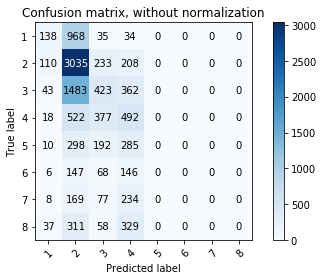

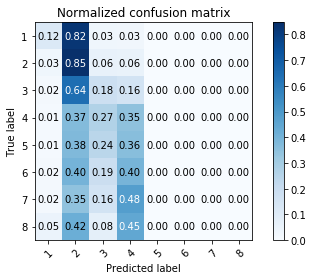

In [29]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names=['1', '2', '3', '4', '5', '6', '7', '8']

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.tight_layout()  # Optional ... often improves the layout 

5- Entrenar una regresión logística y un árbol de decisión usando solo las variables de tipo "delito_xx". Evaluar métricas para el conjunto de training y para test.

In [30]:
# Árbol de decision
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
classification_results(y_test, y_pred)

              precision    recall  f1-score   support

           1       0.40      0.22      0.28      1175
           2       0.46      0.77      0.58      3586
           3       0.31      0.26      0.29      2311
           4       0.25      0.33      0.28      1409
           5       0.20      0.03      0.06       785
           6       0.17      0.02      0.03       367
           7       0.29      0.04      0.07       488
           8       0.29      0.07      0.11       735

   micro avg       0.39      0.39      0.39     10856
   macro avg       0.30      0.22      0.21     10856
weighted avg       0.35      0.39      0.33     10856

accuracy: 0.38568533529845245


Confusion matrix, without normalization
[[ 254  813   63   33    3    1    7    1]
 [ 188 2764  399  181   18    8    9   19]
 [  73 1283  606  299   14   11    9   16]
 [  34  449  413  459   20    2    6   26]
 [  16  234  226  253   26    5    6   19]
 [  13  111   81  125    8    7    7   15]
 [  10  121   84  193   29    3   20   28]
 [  52  249   57  302   15    5    4   51]]
Normalized confusion matrix
[[0.21617021 0.69191489 0.05361702 0.02808511 0.00255319 0.00085106
  0.00595745 0.00085106]
 [0.0524261  0.77077524 0.11126603 0.05047407 0.00501952 0.0022309
  0.00250976 0.00529838]
 [0.03158806 0.55517092 0.26222415 0.12938122 0.00605798 0.00475984
  0.00389442 0.00692341]
 [0.02413059 0.31866572 0.29311568 0.32576295 0.01419446 0.00141945
  0.00425834 0.0184528 ]
 [0.02038217 0.29808917 0.28789809 0.32229299 0.03312102 0.00636943
  0.00764331 0.02420382]
 [0.03542234 0.30245232 0.22070845 0.34059946 0.02179837 0.01907357
  0.01907357 0.04087193]
 [0.0204918  0.24795082 0.1721

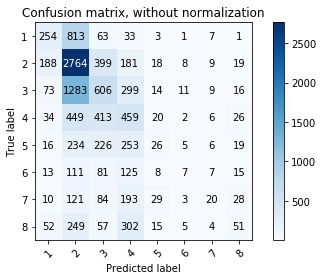

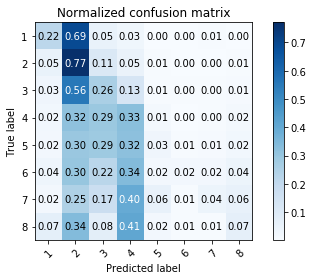

In [31]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.tight_layout()  # Optional ... often improves the layout 

In [32]:
# Regresión Logística
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
classification_results(y_test, y_pred)

/home/lucia/.anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lucia/.anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1175
           2       0.33      0.99      0.50      3586
           3       0.00      0.00      0.00      2311
           4       0.00      0.00      0.00      1409
           5       0.00      0.00      0.00       785
           6       0.00      0.00      0.00       367
           7       0.00      0.00      0.00       488
           8       0.07      0.01      0.01       735

   micro avg       0.33      0.33      0.33     10856
   macro avg       0.05      0.13      0.06     10856
weighted avg       0.11      0.33      0.16     10856

accuracy: 0.32885040530582166


/home/lucia/.anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[   0 1154    0    0    0    0    0   21]
 [   0 3565    0    0    0    0    0   21]
 [   0 2299    0    0    0    0    0   12]
 [   0 1403    0    0    0    0    0    6]
 [   0  784    0    0    0    0    0    1]
 [   0  365    0    0    0    0    0    2]
 [   0  488    0    0    0    0    0    0]
 [   0  730    0    0    0    0    0    5]]
Normalized confusion matrix
[[0.         0.98212766 0.         0.         0.         0.
  0.         0.01787234]
 [0.         0.99414389 0.         0.         0.         0.
  0.         0.00585611]
 [0.         0.99480744 0.         0.         0.         0.
  0.         0.00519256]
 [0.         0.99574166 0.         0.         0.         0.
  0.         0.00425834]
 [0.         0.99872611 0.         0.         0.         0.
  0.         0.00127389]
 [0.         0.99455041 0.         0.         0.         0.
  0.         0.00544959]
 [0.         1.         0.         0.         0.         0.
  0.         0.  

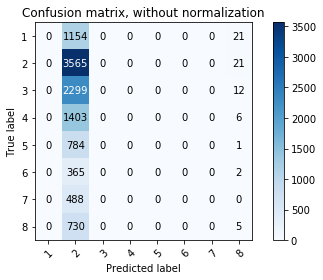

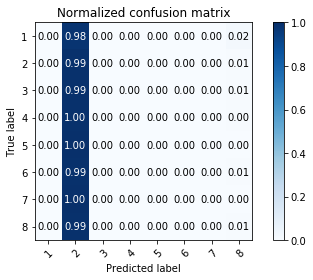

In [33]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.tight_layout()  # Optional ... often improves the layout 

Ambos modelos son malos como el anterior, pero la regresión logística se ve aún peor.

6- Seleccionar 3 variables adicionales para entrenar los modelos. Generar nuevamente conjuntos de training y test. Entrenar y evaluar los modelos de regresión lineal y árbol de decisión.

In [34]:
variables  = ['genero', 'nivel_instruccion', 'ultima_situacion_laboral']
feature_columns = variables + delito_columns
columns = feature_columns + ['duracion_condena_rango']
data = filtered_data[columns]
df4 = pd.DataFrame(data, columns=columns)
df4

df_delitos4 = df4.copy()
df_delitos4[feature_columns] = df_delitos4[feature_columns].astype('category')
cat_columns = df_delitos4.select_dtypes(['category']).columns
df_delitos4[cat_columns] = df_delitos4[cat_columns].apply(lambda x: x.cat.codes)

X = df_delitos4[feature_columns]
y = df_delitos4['duracion_condena_rango']

X_train, X_test, y_train, y_test = train_test_split(X, y)

######################################################################################
###################### ARBOL DE DECISION CLASIFICADOR ################################
######################################################################################
              precision    recall  f1-score   support

           1       0.37      0.19      0.25      1192
           2       0.45      0.75      0.56      3561
           3       0.31      0.25      0.27      2334
           4       0.26      0.28      0.27      1443
           5       0.14      0.04      0.06       767
           6       0.08      0.02      0.03       373
           7       0.15      0.05      0.08       478
           8       0.24      0.15      0.18       708

   micro avg       0.37      0.37      0.37     10856
   macro avg       0.25      0.22      0.21     10856
weighted avg       0.32      0.37      0.33     10856

accuracy: 0.37306558585114225
Confusion matrix, without normalization
[[ 226  813   71  

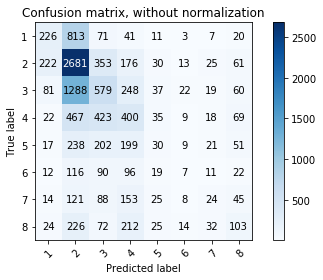

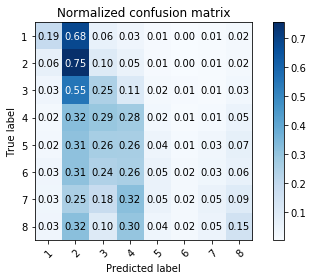

In [35]:
print('######################################################################################')
print('###################### ARBOL DE DECISION CLASIFICADOR ################################')
print('######################################################################################')
clf_tree = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
classification_results(y_test, y_pred)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.tight_layout()  # Optional ... often improves the layout 

######################################################################################
############################ REGRESION LOGÍSTICA #####################################
######################################################################################


/home/lucia/.anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lucia/.anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/lucia/.anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1192
           2       0.33      0.99      0.49      3561
           3       0.00      0.00      0.00      2334
           4       0.00      0.00      0.00      1443
           5       0.00      0.00      0.00       767
           6       0.00      0.00      0.00       373
           7       0.00      0.00      0.00       478
           8       0.05      0.01      0.01       708

   micro avg       0.33      0.33      0.33     10856
   macro avg       0.05      0.12      0.06     10856
weighted avg       0.11      0.33      0.16     10856

accuracy: 0.32562638172439207
Confusion matrix, without normalization
[[   0 1169    0    0    0    0    0   23]
 [   0 3531    3    0    0    0    1   26]
 [   0 2322    0    0    0    0    0   12]
 [   0 1435    0    0    0    0    0    8]
 [   0  763    1    0    0    0    0    3]
 [   0  370    0    0    0    0    0    3]
 [   0  477    1    0

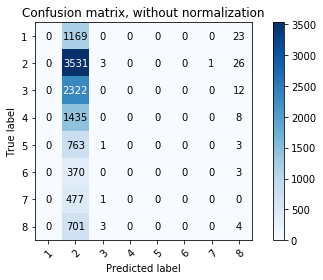

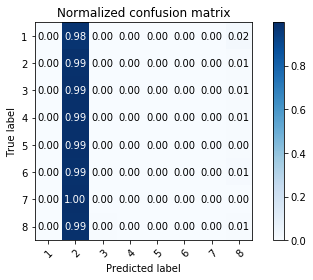

In [36]:
print('######################################################################################')
print('############################ REGRESION LOGÍSTICA #####################################')
print('######################################################################################')
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
classification_results(y_test, y_pred)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.tight_layout()  # Optional ... often improves the layout 

Los modelos no mejoran.

### Ajuste de Hiperparámetros

1- Elegir un modelo (puede ser de regresión o de clasificación) y realizar ajuste de hiperparámetros. Usar grid search y cross-validation. Reportar resultados.

El modelo elegido es una regresión por árbol de decisión.

In [37]:
X = df_delitos2[feature_columns]
y = df_delitos2['duracion_condena']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [38]:
for idx, criterion in enumerate((['mse']), start=1):
    exploring_params = {
        #'learning_rate': ['constant'],
        'splitter': ['best', 'random'],
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, None],
        'min_samples_split' : [2, 4, 6, 8, 10, 20],
        'min_samples_leaf': [1, 10, 20, 25, 29, 30, 31, 32, 35, 40, 50, 100] 
    }
    ad = DecisionTreeRegressor(criterion=criterion, random_state=0)
    model = GridSearchCV(ad, exploring_params, cv=5, scoring='neg_mean_squared_error')
    model.fit(X_train, y_train)
    
    print("# Exploración de hiperparámetros para criterion \"%s\"" % criterion, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")

    print("Puntajes de la grilla:", end="\n\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("Exactitud: %0.4f (+/-%0.04f) para los parámetros %r" % (np.sqrt(-mean), np.sqrt(std), params))
    print()

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE = {:.4f}'.format(rmse), end='\n\n')
    print('Mejores parametros:')
    print(model.best_params_)
    print("================================================", end="\n\n")

# Exploración de hiperparámetros para criterion "mse"

Mejor conjunto de parámetros:
{'max_depth': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'splitter': 'random'}

Puntajes de la grilla:

Exactitud: 64.0104 (+/-10.2456) para los parámetros {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Exactitud: 64.7539 (+/-9.8630) para los parámetros {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Exactitud: 64.0104 (+/-10.2456) para los parámetros {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
Exactitud: 64.7539 (+/-9.8630) para los parámetros {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'random'}
Exactitud: 64.0104 (+/-10.2456) para los parámetros {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 6, 'splitter': 'best'}
Exactitud: 64.7539 (+/-9.8630) para los parámetros {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 6, 'sp

Exactitud: 60.2965 (+/-7.9139) para los parámetros {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 10, 'splitter': 'best'}
Exactitud: 60.3641 (+/-8.4129) para los parámetros {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 10, 'splitter': 'random'}
Exactitud: 60.2965 (+/-7.9139) para los parámetros {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 20, 'splitter': 'best'}
Exactitud: 60.3641 (+/-8.4129) para los parámetros {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 20, 'splitter': 'random'}
Exactitud: 60.2273 (+/-7.8966) para los parámetros {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 2, 'splitter': 'best'}
Exactitud: 60.3779 (+/-9.5837) para los parámetros {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 2, 'splitter': 'random'}
Exactitud: 60.2273 (+/-7.8966) para los parámetros {'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 4, 'splitter': 'best'}
Exactitud: 60.3779 (+/-9.5837) 

Vamos a probar el modelo con los parámetros sugeridos y ver qué resultados arroja.

In [39]:
best_params = model.best_params_

best_model = DecisionTreeRegressor(criterion='mse',
                                   splitter=best_params['splitter'],
                                   max_depth=best_params['max_depth'],
                                   min_samples_split=best_params['min_samples_split'],
                                   min_samples_leaf=best_params['min_samples_leaf'],
                                   random_state=0)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
regression_results(y_test, y_pred)

--------------------------------------------------------------------------------------------
explained_variance:  0.1581
mean_squared_log_error:  1.7276
r2:  0.158
mean_abs_error:  42.0225
median_abs_error:  27.8529
MSE:  3608.287
RMSE:  60.069
--------------------------------------------------------------------------------------------


In [40]:
# Resultados del modelo
best_table = reg_table(X_test, y_test, y_pred)
best_table.head()

,index,genero,nivel_instruccion,ultima_situacion_laboral,delito1,delito2,delito3,delito4,delito5,duracion_condena,condena_predicha,error
0,75330,1,1,2,27,-1,-1,-1,-1,114.0,124.644172,10.644172
1,44694,0,2,0,24,-1,-1,-1,-1,180.0,114.977778,65.022222
2,47874,1,1,2,24,-1,-1,-1,-1,168.0,96.995399,71.004601
3,55051,1,2,2,14,-1,-1,-1,-1,36.0,96.709497,60.709497
4,22525,1,1,1,27,-1,-1,-1,-1,168.0,117.038217,50.961783


In [41]:
best_table.tail()

,index,genero,nivel_instruccion,ultima_situacion_laboral,delito1,delito2,delito3,delito4,delito5,duracion_condena,condena_predicha,error
10851,27929,1,0,2,26,-1,-1,-1,-1,17.0,71.008403,54.008403
10852,60698,1,4,2,26,-1,-1,-1,-1,20.0,74.492439,54.492439
10853,45472,1,4,2,22,24,-1,-1,-1,240.0,72.685185,167.314815
10854,81810,1,0,0,20,-1,-1,-1,-1,42.0,46.470588,4.470588
10855,26973,1,4,1,9,-1,-1,-1,-1,54.0,60.061224,6.061224


In [42]:
best_table.sample(5)

,index,genero,nivel_instruccion,ultima_situacion_laboral,delito1,delito2,delito3,delito4,delito5,duracion_condena,condena_predicha,error
5119,69002,1,4,0,13,-1,-1,-1,-1,72.0,116.929231,44.929231
2632,60609,1,2,2,18,-1,-1,-1,-1,56.0,60.770642,4.770642
6047,20874,1,1,2,27,-1,-1,-1,-1,198.0,124.644172,73.355828
1723,8785,0,4,0,23,-1,-1,-1,-1,48.0,61.000000,13.000000
6748,83698,1,3,0,18,-1,-1,-1,-1,108.0,63.609375,44.390625


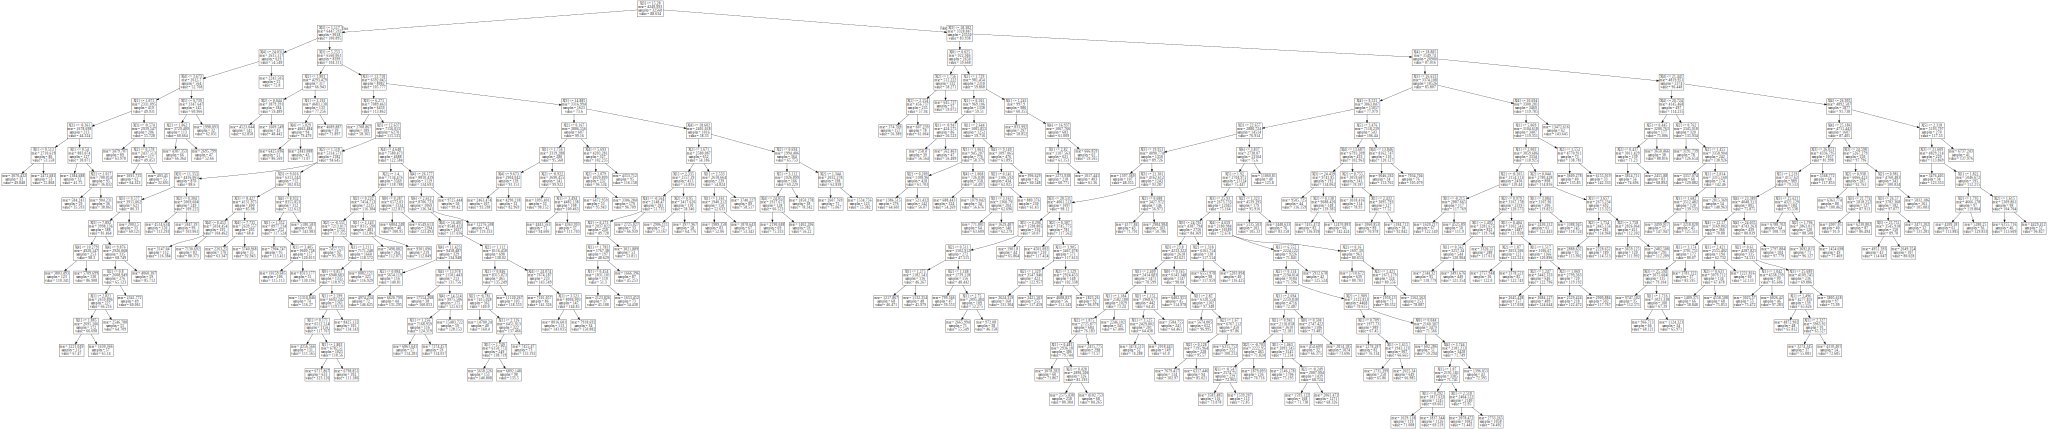

In [43]:
# Gráfico del árbol
dot_data = tree.export_graphviz(best_model, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("arbol2") 
graph

2- Responder: ¿Mejoró sustancialmente el rendimiento de los modelos? ¿Por qué?

No, la verdad que los modelos son muy malos y no mejoran... Creemos que se debe a que tenemos muchos datos categóricos y su representación como valores numéricos no tiene un significado.

### OPCIONAL: Encoding de variables categóricas

Si tienen tiempo, lean el siguiente link: https://www.datacamp.com/community/tutorials/categorical-data.
Y luego ejecuten los siguientes puntos:


1- Usar la función get_dummies() de Pandas para obtener one-hot encoding de las variables categóricas

### One-hot encoding de delitos

In [44]:
import math

def lista_delitos(df):
    delito_columns = ['delito{:d}'.format(i) for i in range(1, 6)]
    df_delito = df[delito_columns]
    
    delitos = pd.unique(df_delito.values.ravel('K')).tolist()
    delitos = list(filter(lambda x: isinstance(x, str), delitos))
    
    n_delitos = len(delitos)
    n_rows = df.shape[0]
    matrix = np.zeros((n_rows, n_delitos), dtype='int')
    delito_dict = {delito: i for i, delito in enumerate(delitos)} 
    
    for i, (index, row) in enumerate(df_delito.iterrows()):
        for delito in row:
            if not isinstance(delito, str):
                continue
            j = delito_dict[delito]
            matrix[i,j] = 1
        
    out_columns = delitos + ['duracion_condena']
    out_df = pd.DataFrame(data=matrix, columns=delitos)
    out_df.index = df.index
    out_df['duracion_condena'] = df['duracion_condena']
    return out_df

new_df = lista_delitos(filtered_data)
new_df.head()

,Otros delitos contra las personas,Delitos contra la seguridad pública,Robo y/o tentativa de robo,Homicidios dolosos (tent.),Infracción ley n° 23.737 (estupefacientes),Amenazas,Violaciones,Homicidios dolosos,Hurto y/o tentativa de hurto,Otros delitos contra la integridad sexual,Privación ilegítima de la libertad,Delitos c/el orden público,Delitos contra el honor,Otros delitos contra la propiedad,Homicidios Culposos,Lesiones Culposas,Lesiones Dolosas,Otros delitos contra la libertad,Delitos contra los poderes publicos,Del. contra la lib. comet. por func. público,Delitos c/ la fe pública,Delitos c/ la administracion pública,Delitos previstos en leyes especiales,Infraccion ley n° 13.944 incumplimiento de deberes,Delitos c/ el estado civil,Contravenciones,Infraccion ley n° 24.769 penal tributaria,Delitos contra la seguridad de la nación,duracion_condena
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26.0
282,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46.0
283,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60.0
284,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103.0
285,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51.0


2- Seleccionar un modelo de regresión o clasificación y evaluar los resultados con las nuevas variables

In [45]:
X = new_df.iloc[:,:-1]
y = new_df['duracion_condena']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Linear regressor
print('Linear regressor')
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_train)
print('Train', regression_results(y_train, y_pred))
y_pred = lin_reg.predict(X_test)
print('Test', regression_results(y_test, y_pred))

## Tree regressor
print('Desicion tree')
tree_reg = DecisionTreeRegressor().fit(X_train, y_train)
y_pred = tree_reg.predict(X_train)
print('Train', regression_results(y_train, y_pred))
y_pred = tree_reg.predict(X_test)
print('Test', regression_results(y_test, y_pred))

Linear regressor
--------------------------------------------------------------------------------------------
explained_variance:  0.1429
mean_squared_log_error:  1.7341
r2:  0.1429
mean_abs_error:  42.0968
median_abs_error:  28.9106
MSE:  3596.1643
RMSE:  59.968
--------------------------------------------------------------------------------------------
Train None
--------------------------------------------------------------------------------------------
explained_variance:  0.1416
mean_squared_log_error:  1.7658
r2:  0.1415
mean_abs_error:  43.3558
median_abs_error:  29.5201
MSE:  3873.325
RMSE:  62.236
--------------------------------------------------------------------------------------------
Test None
Desicion tree
--------------------------------------------------------------------------------------------
explained_variance:  0.1968
mean_squared_log_error:  1.6615
r2:  0.1968
mean_abs_error:  40.2341
median_abs_error:  25.3459
MSE:  3369.8495
RMSE:  58.0504
---------------------